<a href="https://colab.research.google.com/github/ServerBlaster/Self_Learning/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Try loading the following: https://www.kaggle.com/datasets/jessicali9530/stanford-cars-dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [3]:
#Augmentation pipeline
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

traindata = train_datagen.flow_from_directory(
    directory="/content/drive/MyDrive/CarsDataset/dataset",
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    subset='training') # set as training data

testdata = train_datagen.flow_from_directory(
    directory="/content/drive/MyDrive/CarsDataset/dataset", # same directory as training data
    target_size=(224, 224), #changes for each augmentation strategy
    batch_size=4,
    class_mode='binary', #binary for 2 classes, categorical for multiple classes
    subset='validation')

Found 518 images belonging to 2 classes.
Found 129 images belonging to 2 classes.


In [4]:
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


headModel = baseModel.output
headModel = AveragePooling2D((2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)


for layer in baseModel.layers:
	layer.trainable = True

INIT_LR = 1e-2  # =0.0001
EPOCHS = 10
BS = 10

# compile our model
print("[INFO] compiling model...")
opt = Adam()
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")

model.summary()

#create callback
filepath = 'best_model.h5.keras'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss', #for val loss, mode should be min, for val accuracy, mode should be max
                             verbose=1,
                             save_best_only=True,
                             mode='min')
Callbacks = [checkpoint] #Try early stopping as an assignment
history = model.fit(traindata,validation_data = testdata,
                         steps_per_epoch = 100,validation_steps = 10,
                         epochs = EPOCHS,callbacks=Callbacks)

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("final_model.weights.h5")
print("Saved model to disk")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
[INFO] compiling model...
[INFO] training head...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 19,435,329 (74.14 MB)

 Trainable params: 19,435,329 (74.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 33/100 ━━━━━━━━━━━━━━━━━━━━ 3:21 3s/step - accuracy: 0.4501 - loss: 1.9925

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_loss improved from inf to 0.69288, saving model to best_model.h5.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.4732 - loss: 1.4772 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 2/10
 33/100 ━━━━━━━━━━━━━━━━━━━━ 22s 332ms/step - accuracy: 0.5196 - loss: 0.6990
Epoch 2: val_loss did not improve from 0.69288
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 0.5233 - loss: 0.7103 - val_accuracy: 0.4250 - val_loss: 0.6976
Epoch 3/10
 33/100 ━━━━━━━━━━━━━━━━━━━━ 21s 328ms/step - accuracy: 0.4933 - loss: 0.7242
Epoch 3: val_loss did not improve from 0.69288
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.5094 - loss: 0.7412 - val_accuracy: 0.4500 - val_loss: 0.7076
Epoch 4/10
 33/100 ━━━━━━━━━━━━━━━━━━━━ 21s 318ms/step - accuracy: 0.5117 - loss: 0.7055
Epoch 4: val_loss did not improve from 0.69288
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - accuracy: 0.5168 - loss: 0.7101 - val_accuracy: 0.3333 - val_loss: 0.6950
Epoch 5/10
 33/100 ━━━━━━━━━━

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


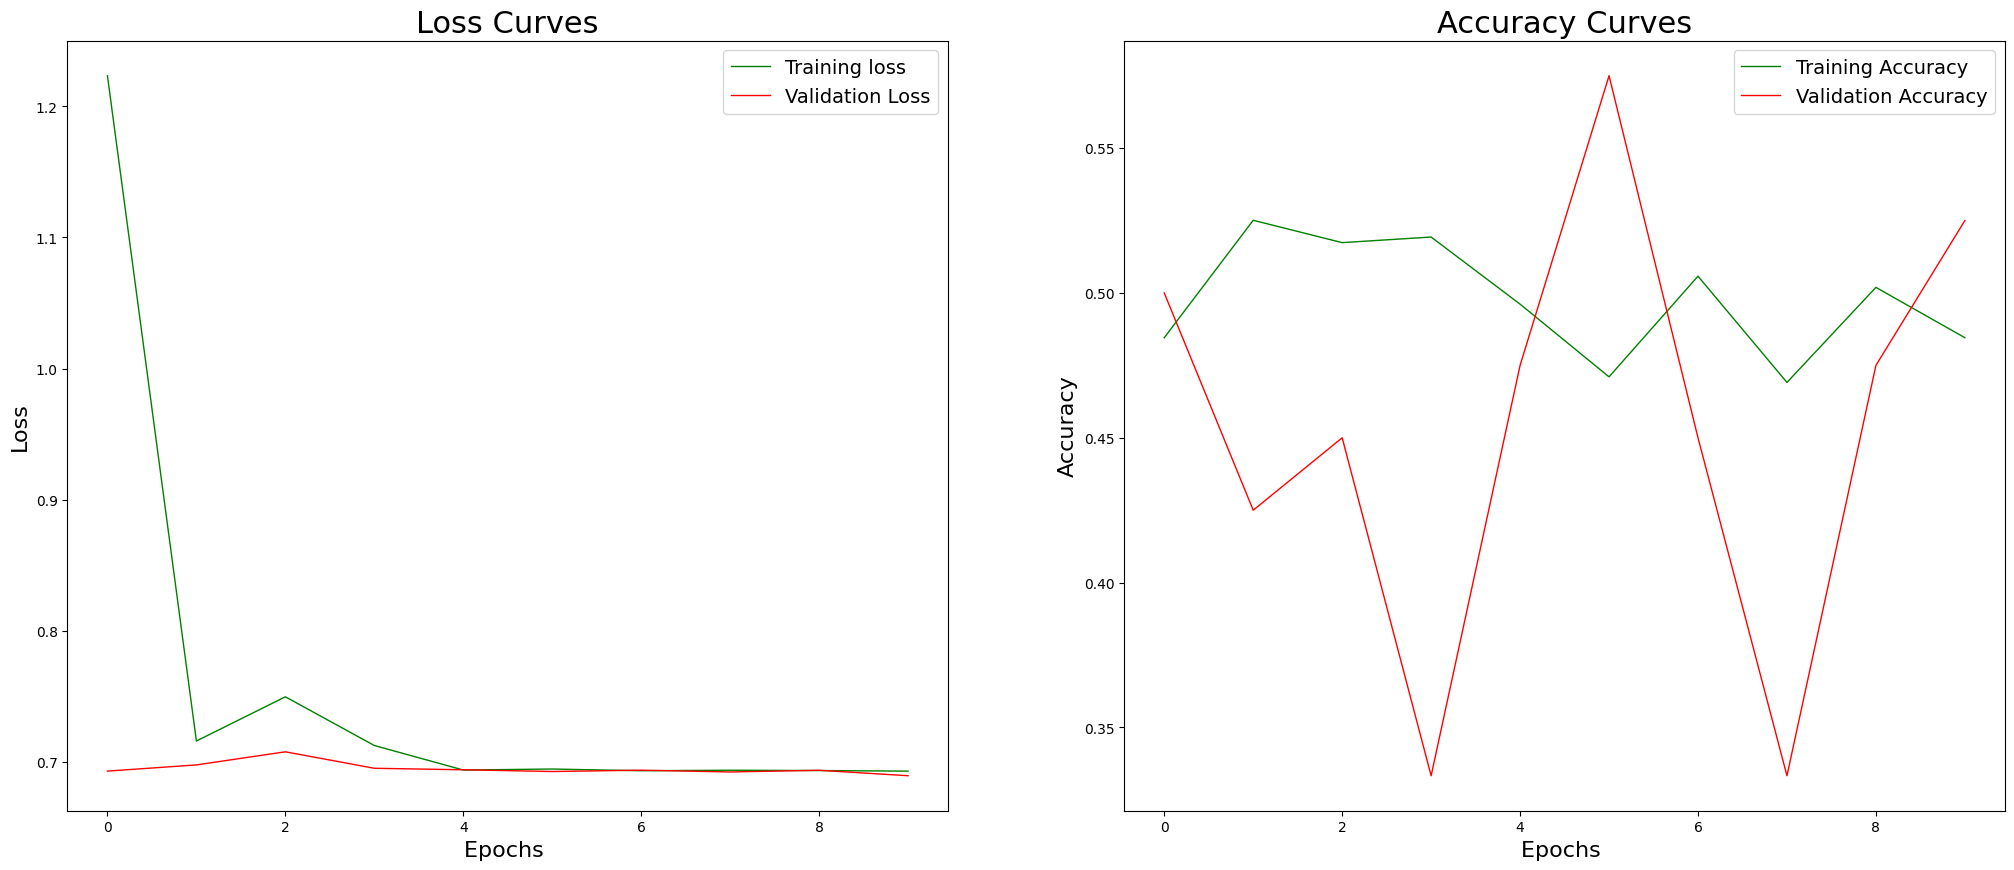

In [5]:
print(history.history.keys())

# Loss Curves
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'],'-g',linewidth=1.0)
plt.plot(history.history['val_loss'],'r',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=14)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=22)

# Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'],'-g',linewidth=1.0)
plt.plot(history.history['val_accuracy'],'r',linewidth=1.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=14)
plt.xlabel('Epochs ',fontsize=16)

plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=22)
plt.show()

In [6]:
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing import image
import h5py
import cv2
from PIL import Image

In [7]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("best_model.h5.keras")
print("Loaded model from disk")

Loaded model from disk


In [8]:
classnames = ['ferrari','honda']

In [9]:
img = cv2.imread("/content/drive/MyDrive/CarsDataset/dataset/Ferrari/008177.jpg")
img = cv2.resize(img,(224,224))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(img)
img_pred = image.img_to_array(im_pil)
img_pred = np.expand_dims(img_pred, axis = 0)
rslt = loaded_model.predict(img_pred)
A = np.array(rslt[0])
maximum_indices = np.where(A==max(rslt[0]))
pred = str(classnames[int(maximum_indices[0][0])])
print (pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
ferrari
